In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# genome-wide methylation

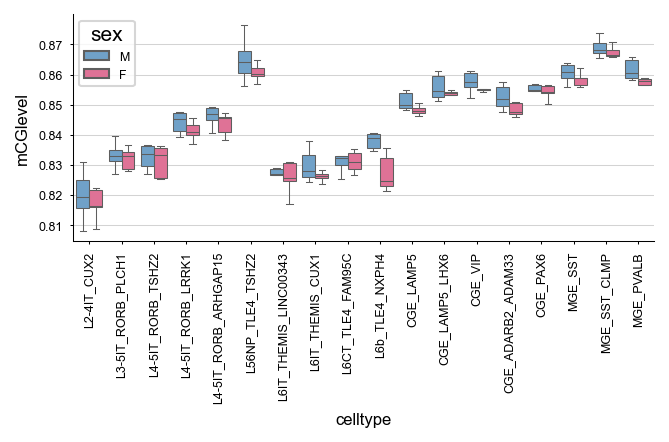

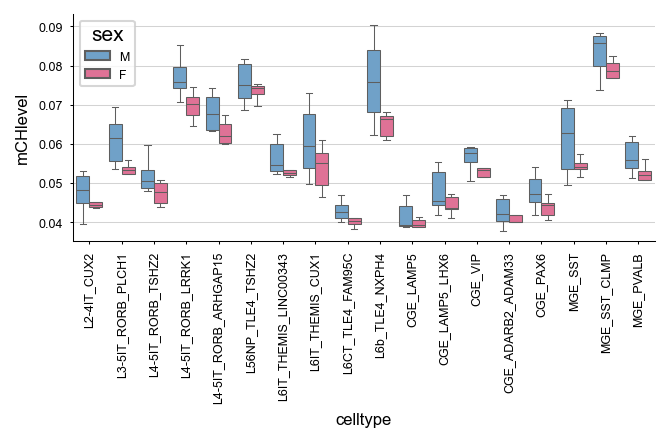

In [3]:
globalm=pd.read_csv('../data/globalMethylation_autosome_rmSNPs.txt.gz',sep='\t',index_col=0)
globalm['celltype']=globalm.index.str.rsplit('-',1).str[0]
globalm['donor']=globalm.index.str.rsplit('-',1).str[1]
globalm['sex']=globalm['donor'].str[1] 

plt.figure(figsize=(5,2),dpi=dpi)
ax=sns.boxplot(data=globalm, x="celltype", y="mCGlevel",order=cziplot.level2_order,
               hue='sex',hue_order=['M','F'],palette=cziplot.sex_palette,
               showfliers=False)
plt.tick_params(axis='x', rotation=90)
plt.grid(axis='y')
df=pd.DataFrame(index=cziplot.level2_order,columns=['p'])
for i in cziplot.level2_order:
    globalm_sub=globalm[globalm['celltype']==i]
    s,p=sc.stats.ranksums(globalm_sub[globalm_sub['sex']=='F']['mCGlevel'],globalm_sub[globalm_sub['sex']=='M']['mCGlevel'])
    df.loc[i,'p']=p
_,df['FDR']=fdrcorrection(df['p'], method='indep', is_sorted=False)

df['sig']=''
df.loc[df['FDR']<0.1,'sig']='*'
stat=df['sig']
pos = range(len(stat))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            0.86,
            stat[tick],
            horizontalalignment='center',
            size=12) 
    
plt.figure(figsize=(5,2),dpi=dpi)
ax=sns.boxplot(data=globalm, x="celltype", y="mCHlevel",order=cziplot.level2_order,
               hue='sex',hue_order=['M','F'],palette=cziplot.sex_palette,
               showfliers=False)
plt.tick_params(axis='x', rotation=90)
plt.grid(axis='y')
df=pd.DataFrame(index=cziplot.level2_order,columns=['p'])
for i in cziplot.level2_order:
    globalm_sub=globalm[globalm['celltype']==i]
    s,p=sc.stats.ranksums(globalm_sub[globalm_sub['sex']=='F']['mCGlevel'],globalm_sub[globalm_sub['sex']=='M']['mCGlevel'])
    df.loc[i,'p']=p
_,df['FDR']=fdrcorrection(df['p'], method='indep', is_sorted=False)

df['sig']=''
df.loc[df['FDR']<0.1,'sig']='*'
stat=df['sig']
pos = range(len(stat))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            0.86,
            stat[tick],
            horizontalalignment='center',
            size=12) 

# compare with GTEx

In [4]:
# our data
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/sexDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata['logFDR']=-np.log10(fulldata['adj.P.Val'])
fulldata=fulldata.set_index('gene_name')
data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]

# GTEx data
! gdown -O /scratch/signif.sbgenes_Frontal_Cortex_BA9.txt  https://drive.google.com/file/d/1-B0Bk6ytjlhGRbEAg5x4pISI-fefWQwz/view?usp=drive_link --fuzzy
! gdown -O /scratch/gencode.v26.geneid.genename.txt  https://drive.google.com/file/d/1Eze9mOkxpo5UHLgZGWDDWArnL0mTNcOs/view?usp=drive_link --fuzzy

ref=pd.read_csv('/scratch/signif.sbgenes_Frontal_Cortex_BA9.txt',index_col=0,sep='\t')
g26dict=pd.read_csv('/scratch/gencode.v26.geneid.genename.txt',sep='\t',header=None, names=['gene_id','gene_name'])
g26dict=dict(zip(g26dict['gene_id'],g26dict['gene_name']))
ref.index=ref.index.map(g26dict)
ref=ref.join(gene_meta[gene_meta['chr']!='chrY'].set_index('gene_name')['chr']).dropna().drop_duplicates()

Downloading...
From: https://drive.google.com/uc?id=1-B0Bk6ytjlhGRbEAg5x4pISI-fefWQwz
To: /scratch/signif.sbgenes_Frontal_Cortex_BA9.txt
100%|████████████████████████████████████████| 197k/197k [00:00<00:00, 3.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Eze9mOkxpo5UHLgZGWDDWArnL0mTNcOs
To: /scratch/gencode.v26.geneid.genename.txt
100%|██████████████████████████████████████| 1.61M/1.61M [00:00<00:00, 13.0MB/s]


## autosome

Text(0, 0.5, 'Sex differentail expression\nlog2(F/M)\n(this study)')

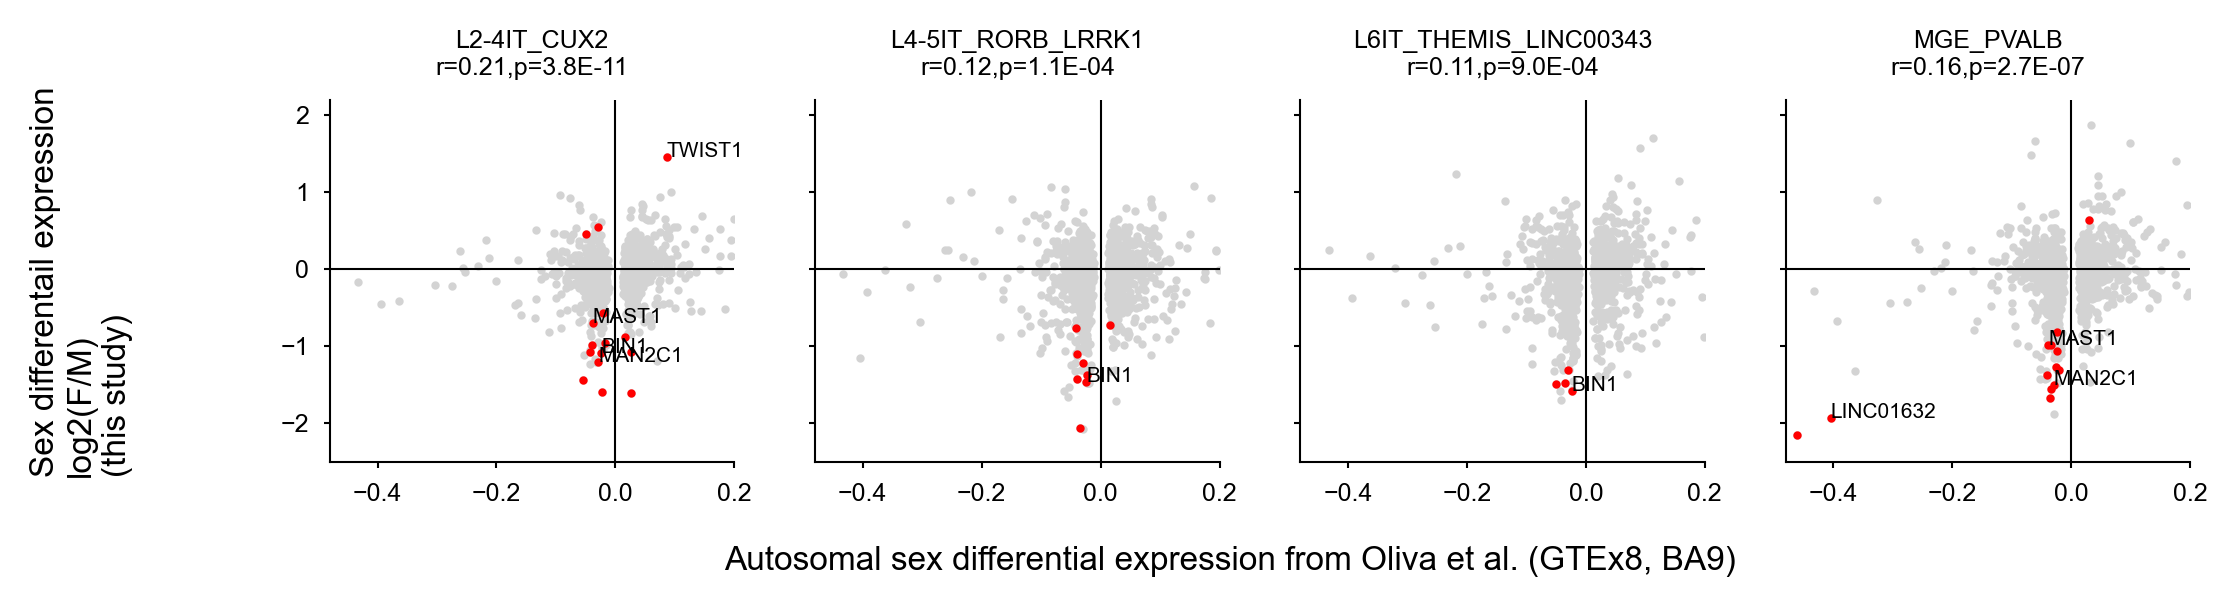

In [5]:
ref_auto=ref[ref['chr']!='chrX'].drop(columns='chr')
fig,axs=plt.subplots(1,4,figsize=(8,1.6),sharex=True,sharey=True,dpi=300)
for i,celltype in enumerate(['L2-4IT_CUX2','L4-5IT_RORB_LRRK1','L6IT_THEMIS_LINC00343','MGE_PVALB']):
    df=ref_auto.join(fulldata[fulldata['celltype']==celltype],rsuffix='_tmp').dropna()
    ax=axs[i]
    c,p=sc.stats.spearmanr(df['effsize'],df['logFC'])
    ax.scatter(df['effsize'],df['logFC'],s=1,c='lightgrey',rasterized=True)
    
    df2=ref_auto.join(data[data['celltype']==celltype],rsuffix='_tmp').dropna()
    ax.scatter(df2['effsize'],df2['logFC'],s=1,c='r')
    n=len(df)
    n0=(df['effsize']*df['logFC']>0).sum()
    ax.set_title(f'{celltype}\nr={c:.2f},p={p:.1E}',fontsize=6)
    ax.axvline(x=0,c='k',linewidth=0.5)
    ax.axhline(y=0,c='k',linewidth=0.5)
    if i==0:
        ax.set_title(f'{celltype}\nr={c:.2f},p={p:.1E}',fontsize=6)
    
    texts=[]
    for i, txt in enumerate(df2.index.intersection(set(['MAST1','TWIST1','BIN1','MAN2C1','LINC01632']))):
        test=ax.text(df2.loc[txt,'effsize'], df2.loc[txt,'logFC'],txt,fontsize=5)
        texts.append(test)
    
ax.set_xlim([-0.48,0.2])
ax.set_ylim([-2.5,2.2])
fig.text(0.5, -0.1, 'Autosomal sex differential expression from Oliva et al. (GTEx8, BA9)', ha='center',fontsize=8)
fig.text(0, 0.5, 'Sex differentail expression\nlog2(F/M)\n(this study)', va='center', rotation='vertical',fontsize=8)

## chrX

Text(0.5, 1.0, '92 X-linked differentially expressed genes in GTEx (BA9)')

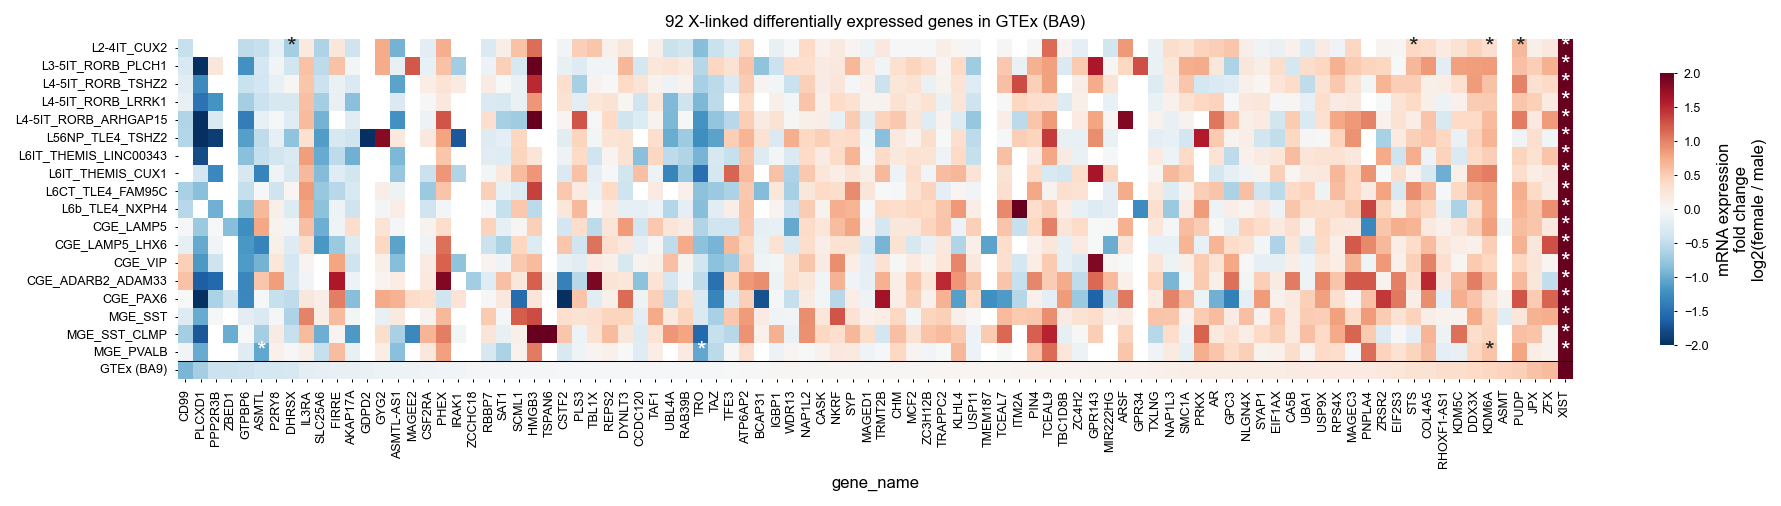

In [6]:
ref_x=ref[ref['chr']=='chrX'].drop(columns='chr')

goi=set(ref_x.index).intersection(set(fulldata.index))
fulldata_df=fulldata.loc[goi].reset_index().pivot(columns='celltype',index='gene_name',values='logFC')[level2_order]
fulldata_df=fulldata_df.join(ref_x[['effsize']]).sort_values('effsize')
fulldata_df=fulldata_df.rename(columns={'effsize':'GTEx (BA9)'}).T

fulldata_df_pval=fulldata.loc[goi].reset_index().pivot(columns='celltype',index='gene_name',values='adj.P.Val')[level2_order]
fulldata_df_pval=fulldata_df_pval.join(ref_x[['lfsr']])
fulldata_df_pval['lfsr']=1 # remove star from GTEx data
fulldata_df_pval=fulldata_df_pval.rename(columns={'lfsr':'GTEx (BA9)'}).T
fulldata_df_pval=fulldata_df_pval.loc[fulldata_df.index,fulldata_df.columns]
fulldata_df_pval
plt.figure(figsize=(15,3),dpi=dpi)
ax=sns.heatmap(fulldata_df,
               cmap='RdBu_r',
               vmin=-2,center=0,vmax=2,
               mask=fulldata_df_pval<=pthres,
               cbar=False
              )
ax=sns.heatmap(fulldata_df,
               cmap='RdBu_r',
               vmin=-2,center=0,vmax=2,
               mask=fulldata_df_pval>pthres,
               cbar_kws={'shrink':0.8,'label':'mRNA expression\nfold change\nlog2(female / male)'},
               annot=np.repeat('*',fulldata_df.shape[0]*fulldata_df.shape[1]).reshape(fulldata_df.shape[0],fulldata_df.shape[1]), fmt="",
               annot_kws={"fontsize":12,"ha": 'center',"va": 'center'}
              )
ax.axhline(y=18,c='k',linewidth=0.5)
ax.set_title(f"{len(fulldata_df.T)} X-linked differentially expressed genes in GTEx (BA9)", fontsize=8)

# Escape gene

In [7]:
# ! gdown -O /scratch/2013_lister_escapee_table4.csv.gz  https://drive.google.com/file/d/1CSSVOKniHuoupCl7BLYZWFzq8Aj8KsWn/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/2017_GTX_escapee_table1.csv.gz  https://drive.google.com/file/d/1mFuszO8zyaKXwuo8qfzf023CR64pi-c3/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/intragenic_mCH.tsv.gz  https://drive.google.com/file/d/139rzP0JKDJ6IkODeeyadEl6V-HIDeDVh/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/allcelltypes_donoraveage_log2cpm+1_chrX.tsv.gz  https://drive.google.com/file/d/1r8kWCv50_66XcibjntJiwV-IV1yWiaPR/view?usp=drive_link --fuzzy
# ! gdown -O /scratch/mCH_genebody_female_male_ratio.tsv.gz  https://drive.google.com/file/d/1mz6QXHrhYfLbPlHr3bMoR-QO1wjUlc3S/view?usp=drive_link --fuzzy

# reference
escapee_mukamel=pd.read_csv('/scratch/2013_lister_escapee_table4.csv.gz',index_col=0)
escapee=pd.read_csv('/scratch/2017_GTX_escapee_table1.csv.gz',index_col='Gene name')
escapee.index=escapee.index.str.split('.').str[0]
escapee = escapee[~escapee.index.duplicated(keep='first')]
ref=escapee_mukamel[['Note']].join(escapee[['Combined XCI status']],how='outer')
ref=ref[ref.index.notna()].replace(np.nan,'no annotation')
lut={'no annotation':'grey','Inactivated genes':'k',' Confirmed escapee':'b', 'Novel predicted escapee':'r',
     'Escapee genes with female hypo-mCG and hypo-mCH':'C0','Escapee genes with female hyper-mCG and hypo-mCH':'C1'}
ref['color']=ref['Note'].map(lut)

# our criteria for escapee
dfch=pd.read_csv('/scratch/intragenic_mCH.tsv.gz',sep='\t',index_col=0,header=[0,1])
dfch=dfch.loc[gene_meta[gene_meta['chr']=='chrX'].index].dropna()
dfch=dfch.T
dfch['sex']=dfch.index.get_level_values(1).str[1]
dfch=dfch[dfch['sex']=='F'].drop(columns='sex')
dfch=dfch.reset_index().groupby(['level_0']).mean()
dfch=dfch[dfch.mean()[dfch.mean()>0.02].index]
goidna=set(dfch.columns)

exp=pd.read_csv('/scratch/allcelltypes_donoraveage_log2cpm+1_chrX.tsv.gz',sep='\t',index_col=0).dropna()
exp=exp.T
exp=exp[exp.min()[exp.min()>0].index]
goirna=set(exp.columns)

dfratio=pd.read_csv('/scratch/mCH_genebody_female_male_ratio.tsv.gz',sep='\t',index_col=0).replace([np.inf,-np.inf],np.nan).dropna().T
dfratio=dfratio[dfratio.max()[dfratio.max()>1.5].index]
goimch=set(dfratio.columns)

goi=goidna.intersection(goimch).intersection(goirna).intersection(set(gene_meta[gene_meta['fn'].isin(['protein_coding','lncRNA'])].index))
goi=list({genedict_idtoname[g] for g in goi})+['XIST']
goi=[ x for x in goi if "-" not in x ]

summary=pd.read_csv('/scratch/mCH_genebody_female_male_ratio.tsv.gz',sep='\t',index_col=0)
summary.index=summary.index.map(genedict_idtoname)
summary=summary.loc[goi]

summary=summary.join(ref[['Combined XCI status','Note']],how='left')
summary['Combined XCI status']=summary['Combined XCI status'].fillna('no annotation')
summary['Note']=summary['Note'].fillna('no annotation')
lut={'no annotation':'white', 'inactive':'k','escape':'r', 'variable':'b'}
col_colors=summary['Combined XCI status'].map(lut)
lut2={'no annotation':'white','Inactivated genes':'k',' Confirmed escapee':'r', 'Novel predicted escapee':'r',
     'Escapee genes with female hypo-mCG and hypo-mCH':'C0','Escapee genes with female hyper-mCG and hypo-mCH':'C1'}
col_colors2=summary['Note'].map(lut2)
color_df = pd.DataFrame({"Lister2013": col_colors2,"GTEX2017": col_colors}, index=summary.index)

summary2=summary.iloc[:,:-2].copy()
summary2[summary2<1]=np.nan
gene_order=summary.mean(axis=1).sort_values(ascending=False).index

In [8]:
from adjustText import adjust_text
def x_scatter(df,celltype,gois,ax):
    df_sub=df.xs(celltype,axis=1).T
    df_sub['sex']=df_sub.index.str[1]
    df_sub=df_sub.groupby('sex').mean().T
    df_sub = df_sub[~df_sub.index.duplicated()]
    sns.scatterplot(x='M',y='F',data=df_sub,s=5,ax=ax,linewidth=0,color='lightgrey',rasterized=True)
    if df_sub.mean().mean()<0.1:
        lims = [0,0.1]
        plt.xlim(lims)
        plt.ylim(lims)
    genes=summary2[celltype].dropna().index.to_list()
    ax.scatter(x=df_sub.loc[genes]['M'],y=df_sub.loc[genes]['F'],s=8, color='k', linewidth=0)
    genes=gois
    ax.scatter(x=df_sub.loc[genes]['M'],y=df_sub.loc[genes]['F'],s=8, facecolors='none', edgecolors='r', linewidth=0.5)
    ax.set_title(cziplot.celltype_simdic[celltype])
    texts=[]
    for i, txt in enumerate(genes):
        test=ax.text(df_sub.loc[txt,'M'], df_sub.loc[txt,'F'],txt)
        texts.append(test)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red',linewidth=0.5),fontsize=6,ax=ax)

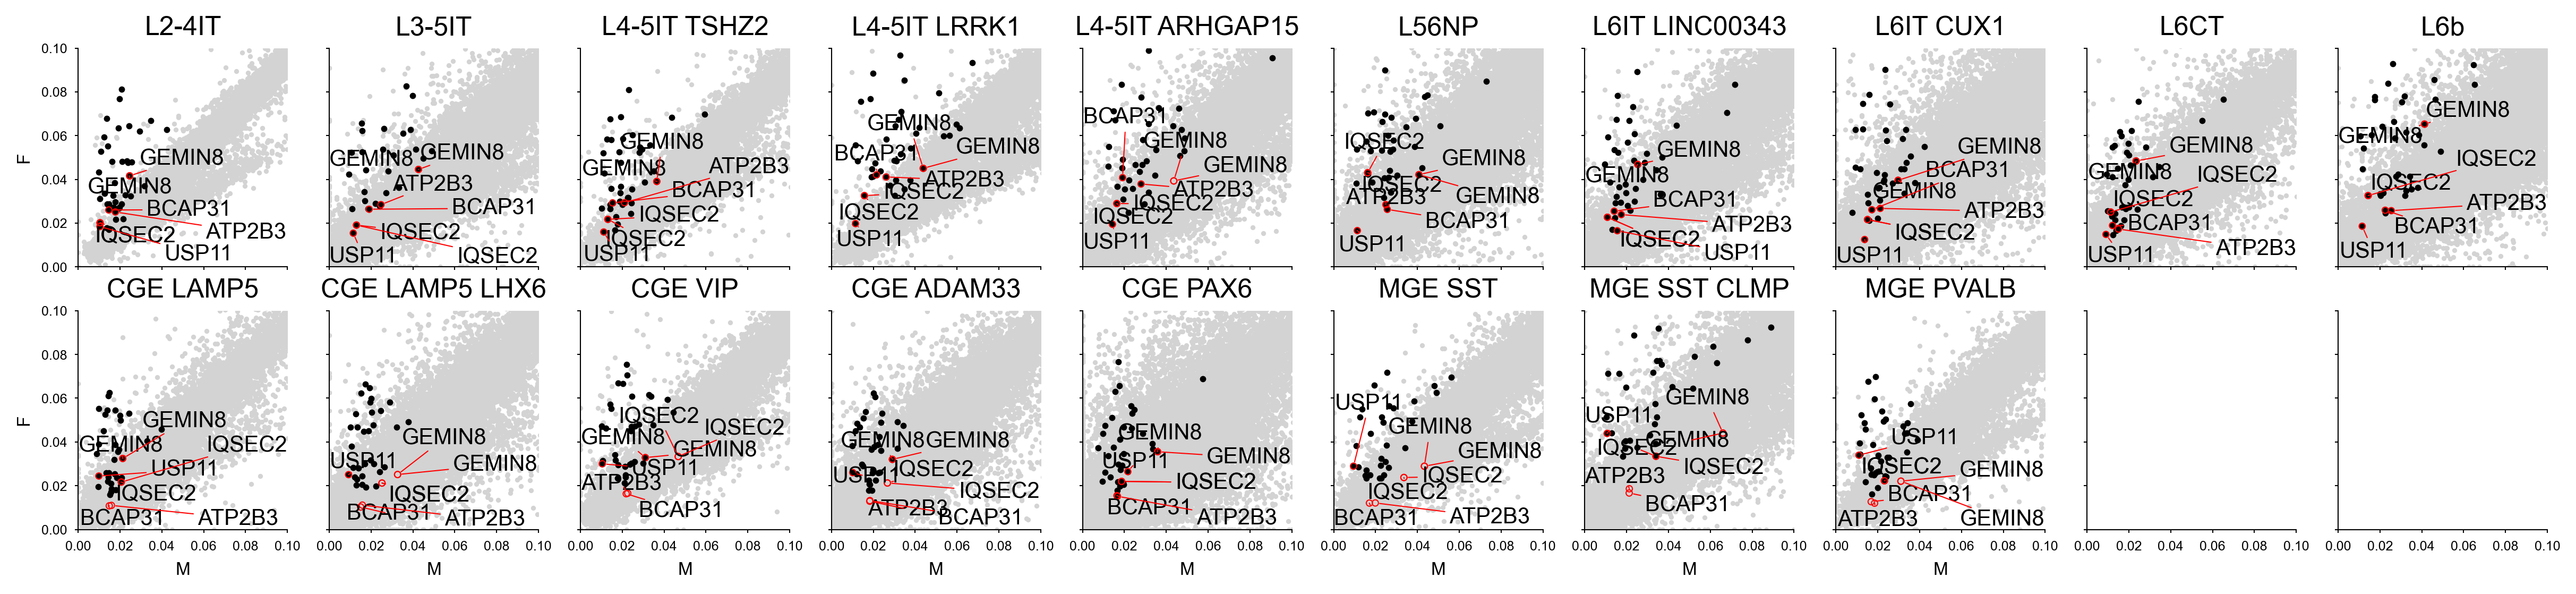

In [9]:
dfch_scatter=pd.read_csv('/scratch/intragenic_mCH.tsv.gz',sep='\t',index_col=0,header=[0,1])
dfch_scatter.index=dfch_scatter.index.map(genedict_idtoname)
genes=['GEMIN8','IQSEC2','USP11','BCAP31','ATP2B3','GEMIN8','IQSEC2'] 

fig,axs=plt.subplots(2,10,figsize=(20,4),dpi=300,sharex=True,sharey=True)
for i,celltype in enumerate(level2_order):
    ax=axs[i//10,i%10]
    x_scatter(dfch_scatter,celltype,genes,ax=ax)

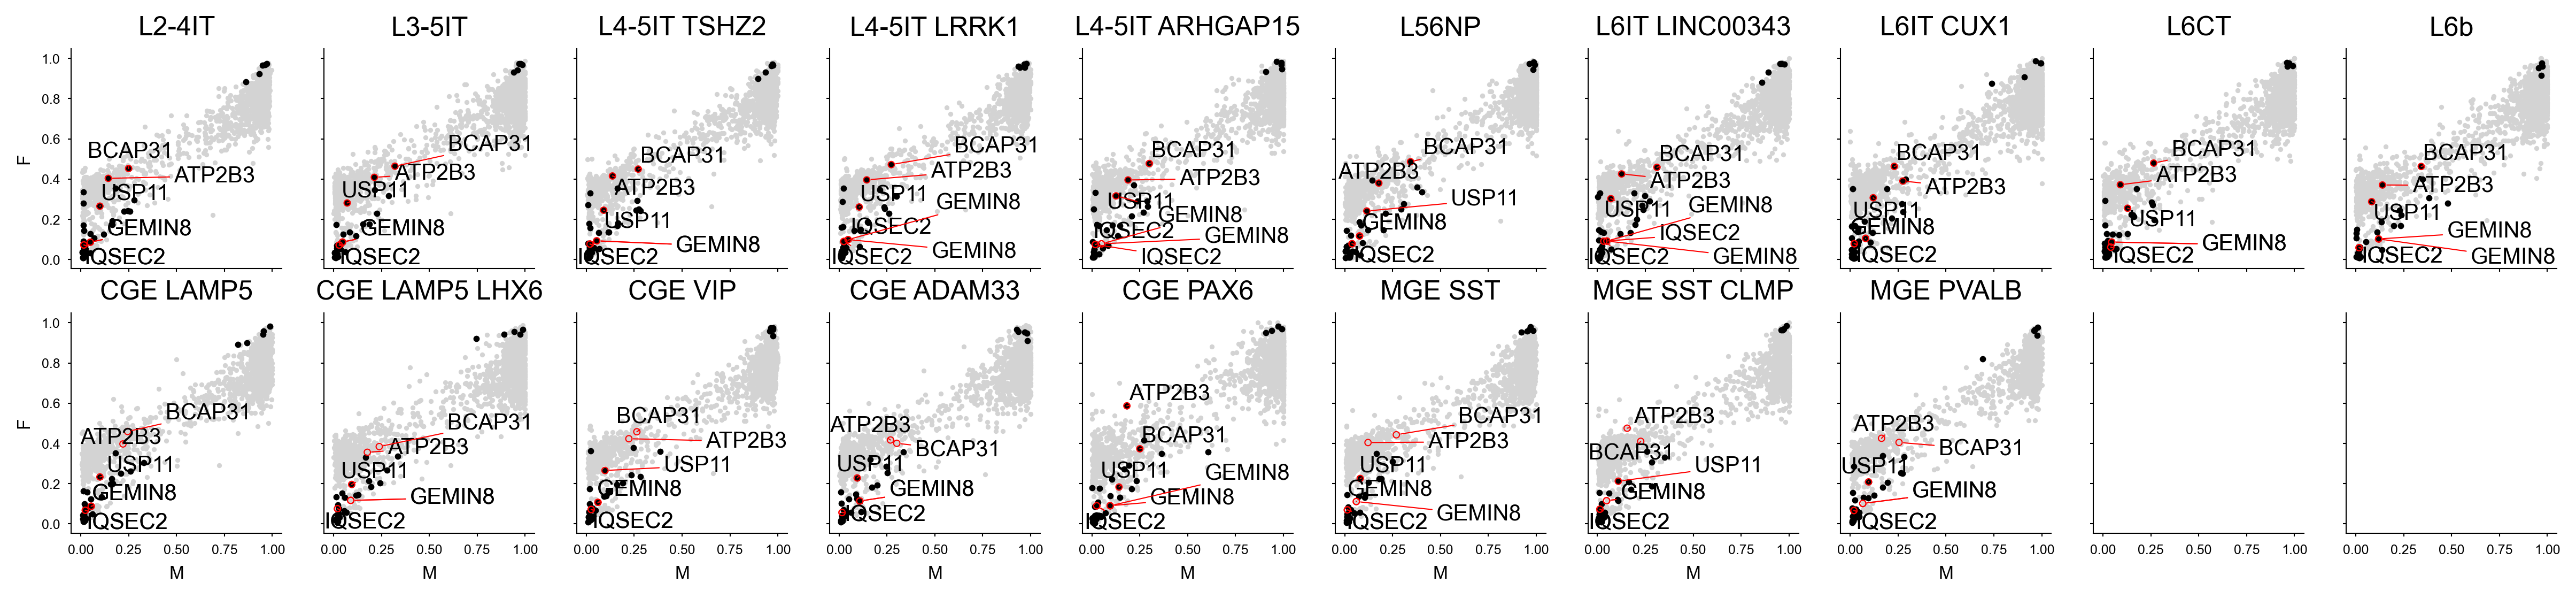

In [10]:
# ! gdown -O /scratch/TSS_mCG_chrX.tsv.gz https://drive.google.com/file/d/1WCwOpTCIQFyZ6929Swa7FH8pSDTl43Vc/view?usp=drive_link --fuzzy
dfcg_scatter=pd.read_csv('/scratch/TSS_mCG_chrX.tsv.gz',sep='\t',index_col=0,header=[0,1])
dfcg_scatter.index=dfcg_scatter.index.map(genedict_idtoname)
    
fig,axs=plt.subplots(2,10,figsize=(20,4),dpi=300,sharex=True,sharey=True)
for i,celltype in enumerate(level2_order):
    ax=axs[i//10,i%10]
    x_scatter(dfcg_scatter,celltype,genes,ax=ax)